# Identifying Particles

Import necessary python libraries

In [2]:
%matplotlib inline
import sys
sys.path.append("..") # Adds the module to path

In [3]:
import deeptrack as dt
import keras
import matplotlib.pyplot as plt
from matplotlib import image
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from random import randint 

print("Import Complete")

Import Complete


## Loading in Images
Graph images, verify that the gold-standard center is accurate enough

[[48.5      50.5       0.55125 ]
 [48.5      54.5       0.55125 ]
 [48.5      52.5       0.55125 ]
 ...
 [51.5      52.5       0.077995]
 [51.5      50.5       0.077995]
 [51.5      51.5       0.077995]]
[48.5     50.5      0.55125]


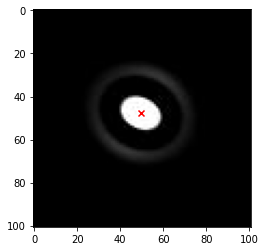

In [4]:
# Load in single image
img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image1.jpg')

# Convert to DeepTrack 2.0 Feature
img_data = dt.features.Dataset(img_data)
output_image = img_data.resolve()

# Display image
plt.imshow(output_image)

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset)

dataset = dataset / 2.0
print(dataset[:, 0:5])

label = dataset[0]
print(label)

# Plot single image against label position
plt.imshow(np.squeeze(output_image), cmap='gray')
plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
plt.show()

Finished loading all images
[48.5     50.5      0.55125]


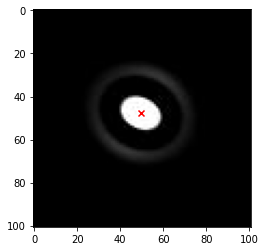

[48.5     50.5      0.55125]


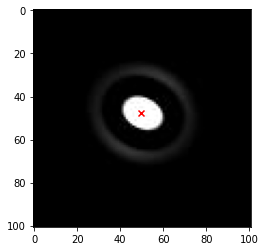

[50.5     50.5      0.63115]


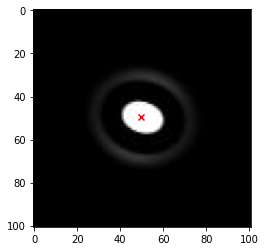

[49.5      52.5       0.077995]


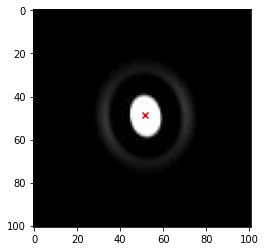

In [5]:
# ==========================================
# Load in all images
NUM_OF_IMAGES = 1000
all_images = []
for i in range(0, NUM_OF_IMAGES):
    image_name = 'image' + str(i + 1) + '.jpg'
#     print("Loading in an image named", image_name)
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/' + image_name)
    all_images.append(img_data)

print("Finished loading all images")

img_data = all_images[0]
img_data = dt.features.Dataset(img_data)

output_image = img_data.resolve()

plt.imshow(np.squeeze(output_image), cmap='gray')
# plt.show()

# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0

# ==========================================
# Sample a few points to show the true label
chosen = [0, 6, 266, 977]
for i in chosen:
    # Select image plot
    img_data = all_images[i]
    img_data = dt.features.Dataset(img_data)
    output_image = img_data.resolve()
    
    # Display image grayscale
    plt.imshow(np.squeeze(output_image), cmap='gray')
    
    # Load in label for selected data
    label = dataset[i]
    print(label)

    # Show image with true label
    plt.imshow(np.squeeze(output_image), cmap='gray')
    plt.scatter(label[1] - 1, label[0] - 1, c="r", marker="x") # 1-indexed, compensate with -1
    plt.show()
original_all_images = all_images.copy()



(1000, 101, 101)


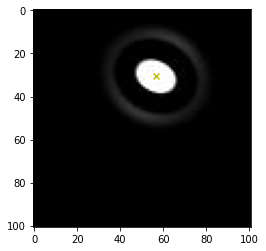

In [6]:
max_width = 101
# Load in Labels
dataset = pd.read_csv('/Users/zhimin/Courtney/winter_research/data/csv/data.csv')
dataset = np.array(dataset, dtype="float64")
dataset = dataset / 2.0
new_all_images = [] # 57x57
# random range is 0-44

old_label = []
for i in range(1, 1001):
    img_data = image.imread('/Users/zhimin/Courtney/winter_research/data/dataset/image' + str(i) + '.jpg')
    # print(img_data)
    C = img_data[22:-22, 22:-22]
# print(C)
    rand_x = randint(0, 44)
    rand_y = randint(0, 44)
    
    D = np.pad(C, ((rand_x, max_width - 57 - rand_x), (rand_y, max_width - 57 - rand_y)), 'constant')
#     print("Old coordinates were ", dataset[0], "Change by", rand_x, rand_y)
    old_label = dataset[0].copy()
    dataset[i - 1] = [dataset[i - 1][0] - 22 + rand_x, dataset[i - 1][1] - 22 + rand_y, dataset[i - 1][2]]
#     print("New coordinates are ", dataset[0])
    
    new_all_images.append(D)
#     plt.imshow(np.squeeze(D), cmap='gray')
#     plt.show()
    
new_all_images = np.array(new_all_images)
print(new_all_images.shape)
# print(new_all_images.shape)
plt.imshow(np.squeeze(new_all_images[0]), cmap='gray')
label = dataset[0]
plt.scatter(label[1] - 1, label[0] - 1, c="y", marker="x") # 1-indexed, compensate with -1
# plt.scatter(old_label[1] - 1, old_label[0] - 1, c="g", marker="x") # 1-indexed, compensate with -1
plt.show()

In [7]:
# # The generator part
# for i in range(0, len(all_images)):
#     img_data = all_images[i] #all_images[0]
#     label = dataset[i]
#     img_data = dt.features.Dataset(img_data)
#     img_data.properties.setdefault('position', [label[1] - 1, label[0] - 1])
#     # print(img_data.properties)
#     all_images[0] = img_data
# all_images = np.array(all_images)

## Training NN
It seems like the labels can only be a single value, so the way it is currently working on it, is to have a separate CNN for x- and y- labels. When combined, they will give the center position attribute for the cell.

In [14]:
x_model = dt.models.convolutional(
    input_shape=(101, 101, 1), 
    conv_layers_dimensions=(1,),
#     dense_top=False,
    activation_function="relu", # flatten it too (? maybe use standard keras here)
    number_of_outputs=1,
    loss='mean_absolute_error',
    optimiser='adam',
    metrics=['accuracy'],
    output_activation="linear",
)

print("Model summary:")
x_model.summary()

Model summary:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 101, 101, 1)       10        
_________________________________________________________________
activation_3 (Activation)    (None, 101, 101, 1)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 51, 51, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2601)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                83264     
_________________________________________________________________
activation_4 (Activation)    (None, 32)     

In [15]:
scaling = StandardScaler()
# scaling.fit(original_all_images)
# original_all_images = scaling.transform(original_all_images)

original_all_images = np.array(original_all_images)
all_images = tf.convert_to_tensor(original_all_images)

all_images = tf.convert_to_tensor(new_all_images)

# Labels into individual sets.
x_dataset = np.zeros(1000)
y_dataset = np.zeros(1000)
angle_dataset = np.zeros(1000)

count = 0
for elem in dataset:
    x_dataset[count] = elem[0]
    y_dataset[count] = elem[1]
    count += 1

# x-coordinate position labels
x_dataset = tf.convert_to_tensor(x_dataset)

# all labels
# dataset = tf.convert_to_tensor(dataset)

In [16]:
print("Fitting the model")
history = x_model.fit(
    x=all_images,
    y=x_dataset,
    epochs=500,
    validation_split=0.4
)

print("Model finished fitting")

Fitting the model
Epoch 1/500
19/19 [==============================] - 1s 36ms/step - loss: 46.4686 - accuracy: 0.0000e+00 - val_loss: 44.2512 - val_accuracy: 0.0000e+00
Epoch 2/500
19/19 [==============================] - 1s 29ms/step - loss: 43.2014 - accuracy: 0.0000e+00 - val_loss: 42.4434 - val_accuracy: 0.0000e+00
Epoch 3/500
19/19 [==============================] - 1s 30ms/step - loss: 41.7537 - accuracy: 0.0000e+00 - val_loss: 41.2472 - val_accuracy: 0.0000e+00
Epoch 4/500
19/19 [==============================] - 1s 32ms/step - loss: 40.6886 - accuracy: 0.0000e+00 - val_loss: 40.3147 - val_accuracy: 0.0000e+00
Epoch 5/500
19/19 [==============================] - 1s 30ms/step - loss: 39.8306 - accuracy: 0.0000e+00 - val_loss: 39.5186 - val_accuracy: 0.0000e+00
Epoch 6/500
19/19 [==============================] - 1s 28ms/step - loss: 39.0626 - accuracy: 0.0000e+00 - val_loss: 38.7755 - val_accuracy: 0.0000e+00
Epoch 7/500
19/19 [==============================] - 1s 32ms/step - lo

19/19 [==============================] - 1s 27ms/step - loss: 14.2120 - accuracy: 0.0000e+00 - val_loss: 14.1596 - val_accuracy: 0.0000e+00
Epoch 55/500
19/19 [==============================] - 0s 27ms/step - loss: 14.0424 - accuracy: 0.0000e+00 - val_loss: 14.0014 - val_accuracy: 0.0000e+00
Epoch 56/500
19/19 [==============================] - 1s 26ms/step - loss: 13.8761 - accuracy: 0.0000e+00 - val_loss: 13.8513 - val_accuracy: 0.0000e+00
Epoch 57/500
19/19 [==============================] - 1s 28ms/step - loss: 13.7177 - accuracy: 0.0000e+00 - val_loss: 13.6995 - val_accuracy: 0.0000e+00
Epoch 58/500
19/19 [==============================] - 0s 26ms/step - loss: 13.5737 - accuracy: 0.0000e+00 - val_loss: 13.5533 - val_accuracy: 0.0000e+00
Epoch 59/500
19/19 [==============================] - 1s 30ms/step - loss: 13.4267 - accuracy: 0.0000e+00 - val_loss: 13.4193 - val_accuracy: 0.0000e+00
Epoch 60/500
19/19 [==============================] - 1s 27ms/step - loss: 13.2883 - accuracy: 

19/19 [==============================] - 1s 42ms/step - loss: 11.3791 - accuracy: 0.0000e+00 - val_loss: 11.5548 - val_accuracy: 0.0000e+00
Epoch 108/500
19/19 [==============================] - 1s 32ms/step - loss: 11.3771 - accuracy: 0.0000e+00 - val_loss: 11.5542 - val_accuracy: 0.0000e+00
Epoch 109/500
19/19 [==============================] - 1s 28ms/step - loss: 11.3762 - accuracy: 0.0000e+00 - val_loss: 11.5531 - val_accuracy: 0.0000e+00
Epoch 110/500
19/19 [==============================] - 1s 27ms/step - loss: 11.3739 - accuracy: 0.0000e+00 - val_loss: 11.5522 - val_accuracy: 0.0000e+00
Epoch 111/500
19/19 [==============================] - 1s 29ms/step - loss: 11.3722 - accuracy: 0.0000e+00 - val_loss: 11.5503 - val_accuracy: 0.0000e+00
Epoch 112/500
19/19 [==============================] - 1s 30ms/step - loss: 11.3695 - accuracy: 0.0000e+00 - val_loss: 11.5487 - val_accuracy: 0.0000e+00
Epoch 113/500
19/19 [==============================] - 1s 27ms/step - loss: 11.3680 - accu

Epoch 161/500
19/19 [==============================] - 0s 26ms/step - loss: 1.6758 - accuracy: 0.0000e+00 - val_loss: 2.0159 - val_accuracy: 0.0000e+00
Epoch 162/500
19/19 [==============================] - 1s 29ms/step - loss: 1.6089 - accuracy: 0.0000e+00 - val_loss: 1.9957 - val_accuracy: 0.0000e+00
Epoch 163/500
19/19 [==============================] - 1s 28ms/step - loss: 1.5823 - accuracy: 0.0000e+00 - val_loss: 1.9572 - val_accuracy: 0.0000e+00
Epoch 164/500
19/19 [==============================] - 1s 26ms/step - loss: 1.5514 - accuracy: 0.0000e+00 - val_loss: 1.9066 - val_accuracy: 0.0000e+00
Epoch 165/500
19/19 [==============================] - 1s 26ms/step - loss: 1.5098 - accuracy: 0.0000e+00 - val_loss: 1.8926 - val_accuracy: 0.0000e+00
Epoch 166/500
19/19 [==============================] - 0s 26ms/step - loss: 1.4874 - accuracy: 0.0000e+00 - val_loss: 1.8662 - val_accuracy: 0.0000e+00
Epoch 167/500
19/19 [==============================] - 0s 26ms/step - loss: 1.4666 - acc

Epoch 215/500
19/19 [==============================] - 1s 27ms/step - loss: 0.9963 - accuracy: 0.0000e+00 - val_loss: 1.4645 - val_accuracy: 0.0000e+00
Epoch 216/500
19/19 [==============================] - 1s 31ms/step - loss: 0.9904 - accuracy: 0.0000e+00 - val_loss: 1.4748 - val_accuracy: 0.0000e+00
Epoch 217/500
19/19 [==============================] - 1s 30ms/step - loss: 0.9801 - accuracy: 0.0000e+00 - val_loss: 1.4829 - val_accuracy: 0.0000e+00
Epoch 218/500
19/19 [==============================] - 1s 27ms/step - loss: 0.9930 - accuracy: 0.0000e+00 - val_loss: 1.4926 - val_accuracy: 0.0000e+00
Epoch 219/500
19/19 [==============================] - 1s 27ms/step - loss: 0.9859 - accuracy: 0.0000e+00 - val_loss: 1.5123 - val_accuracy: 0.0000e+00
Epoch 220/500
19/19 [==============================] - 1s 29ms/step - loss: 1.0128 - accuracy: 0.0000e+00 - val_loss: 1.4764 - val_accuracy: 0.0000e+00
Epoch 221/500
19/19 [==============================] - 1s 32ms/step - loss: 0.9997 - acc

Epoch 269/500
19/19 [==============================] - 0s 26ms/step - loss: 0.9803 - accuracy: 0.0000e+00 - val_loss: 1.4864 - val_accuracy: 0.0000e+00
Epoch 270/500
19/19 [==============================] - 0s 26ms/step - loss: 0.9360 - accuracy: 0.0000e+00 - val_loss: 1.4844 - val_accuracy: 0.0000e+00
Epoch 271/500
19/19 [==============================] - 0s 26ms/step - loss: 0.9082 - accuracy: 0.0000e+00 - val_loss: 1.4687 - val_accuracy: 0.0000e+00
Epoch 272/500
19/19 [==============================] - 1s 27ms/step - loss: 0.9201 - accuracy: 0.0000e+00 - val_loss: 1.4758 - val_accuracy: 0.0000e+00
Epoch 273/500
19/19 [==============================] - 1s 31ms/step - loss: 0.9218 - accuracy: 0.0000e+00 - val_loss: 1.4566 - val_accuracy: 0.0000e+00
Epoch 274/500
19/19 [==============================] - 1s 27ms/step - loss: 0.8864 - accuracy: 0.0000e+00 - val_loss: 1.4479 - val_accuracy: 0.0000e+00
Epoch 275/500
19/19 [==============================] - 1s 29ms/step - loss: 0.8488 - acc

Epoch 323/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6947 - accuracy: 0.0000e+00 - val_loss: 1.3124 - val_accuracy: 0.0000e+00
Epoch 324/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6891 - accuracy: 0.0000e+00 - val_loss: 1.2927 - val_accuracy: 0.0000e+00
Epoch 325/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6869 - accuracy: 0.0000e+00 - val_loss: 1.2769 - val_accuracy: 0.0000e+00
Epoch 326/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6739 - accuracy: 0.0000e+00 - val_loss: 1.2775 - val_accuracy: 0.0000e+00
Epoch 327/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6775 - accuracy: 0.0000e+00 - val_loss: 1.2684 - val_accuracy: 0.0000e+00
Epoch 328/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6796 - accuracy: 0.0000e+00 - val_loss: 1.2675 - val_accuracy: 0.0000e+00
Epoch 329/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6837 - acc

Epoch 377/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6221 - accuracy: 0.0000e+00 - val_loss: 1.2373 - val_accuracy: 0.0000e+00
Epoch 378/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6241 - accuracy: 0.0000e+00 - val_loss: 1.2553 - val_accuracy: 0.0000e+00
Epoch 379/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6204 - accuracy: 0.0000e+00 - val_loss: 1.2493 - val_accuracy: 0.0000e+00
Epoch 380/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6139 - accuracy: 0.0000e+00 - val_loss: 1.2400 - val_accuracy: 0.0000e+00
Epoch 381/500
19/19 [==============================] - 0s 26ms/step - loss: 0.6180 - accuracy: 0.0000e+00 - val_loss: 1.2404 - val_accuracy: 0.0000e+00
Epoch 382/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6126 - accuracy: 0.0000e+00 - val_loss: 1.2399 - val_accuracy: 0.0000e+00
Epoch 383/500
19/19 [==============================] - 1s 29ms/step - loss: 0.6113 - acc

Epoch 431/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6205 - accuracy: 0.0000e+00 - val_loss: 1.2947 - val_accuracy: 0.0000e+00
Epoch 432/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6229 - accuracy: 0.0000e+00 - val_loss: 1.2847 - val_accuracy: 0.0000e+00
Epoch 433/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6127 - accuracy: 0.0000e+00 - val_loss: 1.3276 - val_accuracy: 0.0000e+00
Epoch 434/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6126 - accuracy: 0.0000e+00 - val_loss: 1.2942 - val_accuracy: 0.0000e+00
Epoch 435/500
19/19 [==============================] - 1s 34ms/step - loss: 0.6197 - accuracy: 0.0000e+00 - val_loss: 1.3184 - val_accuracy: 0.0000e+00
Epoch 436/500
19/19 [==============================] - 1s 30ms/step - loss: 0.6239 - accuracy: 0.0000e+00 - val_loss: 1.3138 - val_accuracy: 0.0000e+00
Epoch 437/500
19/19 [==============================] - 1s 27ms/step - loss: 0.6148 - acc

Epoch 485/500
19/19 [==============================] - 1s 30ms/step - loss: 0.5831 - accuracy: 0.0000e+00 - val_loss: 1.2282 - val_accuracy: 0.0000e+00
Epoch 486/500
19/19 [==============================] - 0s 26ms/step - loss: 0.5801 - accuracy: 0.0000e+00 - val_loss: 1.2223 - val_accuracy: 0.0000e+00
Epoch 487/500
19/19 [==============================] - 1s 27ms/step - loss: 0.5757 - accuracy: 0.0000e+00 - val_loss: 1.2155 - val_accuracy: 0.0000e+00
Epoch 488/500
19/19 [==============================] - 1s 29ms/step - loss: 0.5871 - accuracy: 0.0000e+00 - val_loss: 1.2122 - val_accuracy: 0.0000e+00
Epoch 489/500
19/19 [==============================] - 1s 29ms/step - loss: 0.5831 - accuracy: 0.0000e+00 - val_loss: 1.2163 - val_accuracy: 0.0000e+00
Epoch 490/500
19/19 [==============================] - 1s 29ms/step - loss: 0.5901 - accuracy: 0.0000e+00 - val_loss: 1.2101 - val_accuracy: 0.0000e+00
Epoch 491/500
19/19 [==============================] - 1s 29ms/step - loss: 0.5959 - acc

In [17]:
x_predicted = np.array(x_model.predict_on_batch(all_images))
# print(x_predicted)
# print(x_dataset)

count = 0
for i in range(0, 1000):
    difference = round(round(x_predicted[i][0], 1) - float(x_dataset[i]), 2)
    if abs(difference) <= 1.0:
        count += 1
    else:
        print(difference, "(", round(x_predicted[i][0], 1), ",", float(x_dataset[i]), ")")


print("Number of correct are", count)

# 357 correct within 0.5
# 613 correct within 1.0

-1.9 ( 29.6 , 31.5 )
1.1 ( 35.6 , 34.5 )
1.1 ( 29.6 , 28.5 )
2.7 ( 64.2 , 61.5 )
1.3 ( 47.8 , 46.5 )
1.1 ( 29.6 , 28.5 )
2.0 ( 69.5 , 67.5 )
1.6 ( 28.1 , 26.5 )
1.8 ( 53.3 , 51.5 )
1.1 ( 69.6 , 68.5 )
1.5 ( 62.0 , 60.5 )
2.6 ( 41.1 , 38.5 )
-2.0 ( 30.5 , 32.5 )
1.1 ( 38.6 , 37.5 )
2.0 ( 65.5 , 63.5 )
1.8 ( 53.3 , 51.5 )
3.8 ( 58.3 , 54.5 )
3.0 ( 65.5 , 62.5 )
1.1 ( 41.6 , 40.5 )
2.0 ( 37.5 , 35.5 )
-1.1 ( 46.4 , 47.5 )
1.3 ( 64.8 , 63.5 )
-1.5 ( 57.0 , 58.5 )
-1.2 ( 53.3 , 54.5 )
-1.9 ( 40.6 , 42.5 )
-1.1 ( 50.4 , 51.5 )
-2.5 ( 44.0 , 46.5 )
-1.9 ( 35.6 , 37.5 )
-2.0 ( 65.5 , 67.5 )
-2.0 ( 70.5 , 72.5 )
1.1 ( 29.6 , 28.5 )
-2.0 ( 67.5 , 69.5 )
1.7 ( 49.2 , 47.5 )
-1.9 ( 55.6 , 57.5 )
-2.0 ( 37.5 , 39.5 )
-1.7 ( 48.8 , 50.5 )
-2.0 ( 37.5 , 39.5 )
1.2 ( 52.7 , 51.5 )
1.1 ( 29.6 , 28.5 )
1.1 ( 29.6 , 28.5 )
-2.2 ( 53.3 , 55.5 )
1.6 ( 70.1 , 68.5 )
-1.8 ( 43.7 , 45.5 )
-1.5 ( 41.0 , 42.5 )
-2.1 ( 59.4 , 61.5 )
1.9 ( 54.4 , 52.5 )
1.1 ( 27.6 , 26.5 )
-1.5 ( 44.0 , 45.5 )
-1.1 ( 59.4 , 60.5 

In [18]:
print(set(np.array(x_dataset)))

{26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5, 33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5, 44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5, 55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5, 66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5}


Final loss: 6.373
Final accuracy: 0.0
Final val_loss: 6.471
Final val_accuracy: 0.0


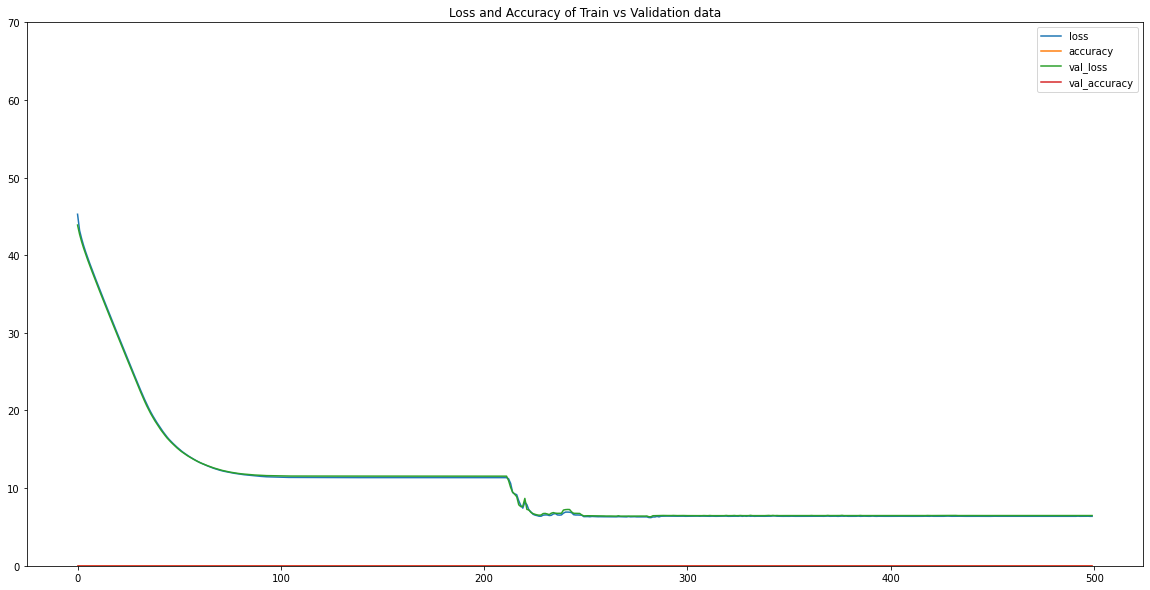

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0

In [13]:
def plot_history(history, ylim=70): # Thank you catkins
    """
    Plot train and validation accuracy and loss in one chart.
    :param history: The dictionary containing the accuracy and loss history.
    """
    keep = ""
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_title('Loss and Accuracy of Train vs Validation data')
    for key, value in history.history.items():
        ax.plot(value, label=key)
        print(f'Final {key}: {round(value[-1], 3)}')
        if key == "accuracy":
            keep = value
    plt.ylim([0,ylim])
    ax.legend()
    plt.show()
    return keep
plot_history(history)

In [13]:
# y_model = dt.models.convolutional(
#     input_shape=(101, 101, 1), 
#     number_of_outputs=1,
#     loss='mean_absolute_error',
#     optimiser='adam',
#     metrics=['mean_absolute_error', 'accuracy']
# )

# print("Model summary:")
# y_model.summary()

# print("Fitting the model")
# history = y_model.fit(
#     x=all_images,
#     y=y_dataset,
#     epochs=30,
#     validation_split=0.4
# )

# print("Model finished fitting")

In [14]:
# [[61.498257]
#  [40.661373]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [34.33226 ]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [32.626095]
#  [32.645126]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [40.66136 ]
#  [40.79866 ]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.49822 ]
#  [46.024326]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [45.823006]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [34.33226 ]
#  [32.626095]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [34.33226 ]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [34.33226 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [40.661335]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66193 ]
#  [61.498257]
#  [61.498257]
#  [46.341908]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [34.33226 ]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [40.66136 ]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [34.33226 ]
#  [40.66136 ]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.495907]
#  [32.626095]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [46.024326]
#  [34.33226 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [32.626095]
#  [61.498234]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [34.33226 ]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [34.33214 ]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.661366]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [46.024326]
#  [46.024326]
#  [61.498257]
#  [40.66136 ]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [40.66136 ]
#  [32.626095]
#  [32.626095]
#  [46.024326]
#  [32.626095]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [61.498257]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [46.024326]
#  [32.626095]
#  [40.66136 ]
#  [32.626095]
#  [61.498257]
#  [46.024326]
#  [61.498253]
#  [32.626095]]
# tf.Tensor(
# [57.5 39.5 68.5 53.5 53.5 48.5 34.5 57.5 64.5 43.5 51.5 71.5 27.5 51.5
#  46.5 57.5 57.5 37.5 47.5 51.5 55.5 49.5 39.5 42.5 58.5 31.5 32.5 71.5
#  37.5 70.5 68.5 26.5 68.5 51.5 54.5 45.5 47.5 58.5 32.5 41.5 30.5 49.5
#  37.5 41.5 29.5 54.5 31.5 67.5 49.5 48.5 41.5 60.5 53.5 29.5 29.5 65.5
#  62.5 55.5 43.5 41.5 66.5 49.5 45.5 33.5 47.5 60.5 54.5 61.5 67.5 69.5
#  70.5 49.5 70.5 53.5 67.5 44.5 37.5 35.5 36.5 59.5 33.5 32.5 53.5 67.5
#  72.5 50.5 41.5 44.5 38.5 53.5 50.5 39.5 71.5 30.5 35.5 45.5 51.5 60.5
#  39.5 29.5 40.5 39.5 35.5 44.5 47.5 46.5 50.5 68.5 39.5 63.5 43.5 31.5
#  50.5 43.5 49.5 70.5 46.5 41.5 40.5 70.5 45.5 68.5 33.5 38.5 41.5 36.5
#  31.5 45.5 40.5 69.5 60.5 32.5 63.5 29.5 61.5 46.5 69.5 30.5 34.5 46.5
#  67.5 61.5 61.5 62.5 55.5 51.5 46.5 36.5 53.5 53.5 53.5 45.5 50.5 28.5
#  67.5 45.5 36.5 56.5 60.5 59.5 42.5 30.5 29.5 46.5 34.5 48.5 41.5 54.5
#  48.5 56.5 26.5 33.5 50.5 50.5 28.5 29.5 32.5 45.5 48.5 70.5 40.5 43.5
#  71.5 30.5 71.5 67.5 73.5 51.5 56.5 62.5 59.5 28.5 70.5 45.5 52.5 57.5
#  29.5 30.5 42.5 68.5 41.5 36.5 58.5 29.5 61.5 60.5 27.5 41.5 47.5 42.5
#  60.5 46.5 50.5 52.5 56.5 27.5 57.5 45.5 39.5 35.5 67.5 48.5 63.5 47.5
#  51.5 57.5 65.5 39.5 64.5 41.5 69.5 43.5 52.5 45.5 43.5 26.5 34.5 64.5
#  36.5 67.5 42.5 59.5 60.5 59.5 32.5 65.5 59.5 30.5 40.5 41.5 59.5 47.5
#  57.5 51.5 33.5 56.5 70.5 51.5 35.5 61.5 72.5 56.5 44.5 45.5 28.5 40.5
#  67.5 62.5 69.5 54.5 28.5 57.5 59.5 63.5 49.5 32.5 40.5 35.5 33.5 37.5
#  66.5 42.5 46.5 29.5 49.5 38.5 64.5 56.5 35.5 61.5 43.5 38.5 72.5 29.5
#  46.5 58.5 63.5 28.5 61.5 63.5 54.5 63.5 58.5 41.5 47.5 44.5 45.5 46.5
#  69.5 57.5 39.5 65.5 32.5 47.5 36.5 33.5 70.5 60.5 64.5 68.5 48.5 57.5
#  56.5 57.5 56.5 47.5 67.5 72.5 30.5 69.5 65.5 68.5 48.5 31.5 62.5 28.5
#  27.5 31.5 32.5 64.5 67.5 64.5 32.5 30.5 39.5 62.5 42.5 63.5 47.5 54.5
#  49.5 71.5 30.5 36.5 72.5 53.5 61.5 58.5 55.5 68.5 63.5 28.5 43.5 63.5
#  58.5 42.5 44.5 59.5 62.5 30.5 66.5 46.5 68.5 60.5 39.5 60.5 36.5 35.5
#  42.5 44.5 52.5 58.5 42.5 46.5 36.5 70.5 36.5 58.5 71.5 30.5 45.5 45.5
#  45.5 40.5 34.5 69.5 65.5 47.5 48.5 46.5 32.5 60.5 52.5 41.5 34.5 27.5
#  67.5 60.5 26.5 64.5 41.5 31.5 40.5 38.5 34.5 39.5 68.5 67.5 52.5 38.5
#  29.5 32.5 69.5 36.5 42.5 33.5 58.5 61.5 51.5 46.5 52.5 51.5 61.5 56.5
#  59.5 34.5 69.5 41.5 61.5 38.5 39.5 59.5 43.5 31.5 70.5 41.5 47.5 72.5
#  52.5 51.5 46.5 58.5 65.5 38.5 61.5 49.5 37.5 29.5 59.5 51.5 28.5 51.5
#  58.5 39.5 58.5 41.5 69.5 36.5 56.5 50.5 37.5 38.5 42.5 67.5 57.5 30.5
#  58.5 45.5 60.5 35.5 44.5 40.5 53.5 31.5 37.5 55.5 36.5 36.5 72.5 59.5
#  68.5 39.5 38.5 40.5 64.5 62.5 42.5 47.5 43.5 59.5 34.5 69.5 31.5 67.5
#  35.5 41.5 32.5 56.5 56.5 39.5 34.5 37.5 44.5 28.5 66.5 56.5 63.5 37.5
#  57.5 69.5 68.5 52.5 63.5 32.5 39.5 66.5 56.5 65.5 50.5 50.5 39.5 71.5
#  60.5 30.5 64.5 32.5 68.5 52.5 59.5 55.5 55.5 63.5 52.5 36.5 48.5 67.5
#  29.5 38.5 40.5 37.5 55.5 52.5 41.5 73.5 50.5 72.5 71.5 61.5 40.5 29.5
#  53.5 70.5 67.5 31.5 62.5 45.5 29.5 56.5 69.5 59.5 31.5 40.5 43.5 58.5
#  47.5 36.5 52.5 37.5 68.5 49.5 42.5 71.5 54.5 47.5 60.5 43.5 40.5 46.5
#  51.5 42.5 71.5 62.5 57.5 38.5 43.5 45.5 67.5 42.5 63.5 60.5 33.5 63.5
#  42.5 34.5 55.5 68.5 31.5 43.5 56.5 45.5 43.5 59.5 51.5 62.5 30.5 55.5
#  35.5 29.5 63.5 33.5 37.5 70.5 57.5 69.5 44.5 39.5 48.5 40.5 42.5 55.5
#  32.5 62.5 70.5 39.5 53.5 68.5 33.5 31.5 29.5 37.5 54.5 63.5 61.5 64.5
#  63.5 35.5 50.5 68.5 71.5 53.5 72.5 46.5 60.5 66.5 53.5 56.5 51.5 70.5
#  67.5 47.5 38.5 47.5 72.5 64.5 48.5 49.5 72.5 34.5 47.5 32.5 61.5 67.5
#  56.5 39.5 68.5 56.5 55.5 33.5 70.5 27.5 36.5 59.5 68.5 30.5 33.5 31.5
#  44.5 51.5 68.5 55.5 63.5 73.5 32.5 70.5 33.5 50.5 37.5 35.5 45.5 72.5
#  33.5 65.5 32.5 55.5 43.5 54.5 42.5 67.5 48.5 64.5 37.5 68.5 52.5 67.5
#  40.5 71.5 53.5 52.5 64.5 51.5 51.5 64.5 58.5 49.5 50.5 70.5 52.5 31.5
#  27.5 27.5 52.5 57.5 55.5 41.5 68.5 45.5 31.5 52.5 27.5 67.5 51.5 51.5
#  48.5 61.5 59.5 63.5 72.5 59.5 29.5 50.5 35.5 35.5 65.5 29.5 65.5 60.5
#  30.5 36.5 32.5 37.5 54.5 69.5 58.5 53.5 49.5 72.5 52.5 45.5 38.5 42.5
#  37.5 39.5 42.5 66.5 67.5 68.5 30.5 49.5 34.5 66.5 48.5 41.5 52.5 40.5
#  30.5 32.5 68.5 59.5 52.5 52.5 61.5 66.5 45.5 45.5 62.5 30.5 69.5 43.5
#  37.5 37.5 51.5 28.5 31.5 30.5 62.5 31.5 40.5 54.5 66.5 37.5 65.5 69.5
#  65.5 71.5 42.5 57.5 57.5 34.5 37.5 63.5 67.5 28.5 71.5 43.5 52.5 70.5
#  44.5 47.5 39.5 59.5 49.5 44.5 36.5 30.5 35.5 27.5 45.5 35.5 46.5 37.5
#  35.5 47.5 50.5 60.5 48.5 65.5 34.5 52.5 38.5 41.5 63.5 62.5 65.5 71.5
#  49.5 28.5 65.5 31.5 49.5 63.5 44.5 37.5 58.5 53.5 67.5 44.5 70.5 57.5
#  34.5 69.5 67.5 46.5 52.5 38.5 52.5 55.5 29.5 59.5 49.5 42.5 37.5 51.5
#  45.5 41.5 66.5 49.5 31.5 43.5 33.5 29.5 45.5 57.5 33.5 65.5 66.5 64.5
#  51.5 30.5 49.5 57.5 38.5 52.5 54.5 47.5 55.5 45.5 62.5 35.5 52.5 65.5
#  53.5 35.5 40.5 55.5 33.5 40.5 58.5 68.5 33.5 35.5 52.5 54.5 52.5 31.5
#  54.5 68.5 40.5 49.5 33.5 56.5 42.5 31.5 68.5 51.5 39.5 28.5 49.5 59.5
#  67.5 53.5 42.5 66.5 73.5 60.5 37.5 67.5 55.5 55.5 50.5 56.5 44.5 55.5
#  60.5 49.5 38.5 30.5 59.5 54.5 46.5 48.5 36.5 71.5 64.5 40.5 49.5 38.5
#  40.5 45.5 58.5 42.5 70.5 53.5 32.5 52.5 65.5 33.5 66.5 66.5 59.5 45.5
#  31.5 34.5 50.5 31.5 71.5 71.5 68.5 58.5 57.5 44.5 36.5 38.5 43.5 33.5
#  40.5 36.5 55.5 49.5 62.5 30.5], shape=(1000,), dtype=float64)

In [15]:
# y_predicted = y_model.predict_on_batch(all_images)
# print(y_predicted)
# print(y_dataset)